In [5]:
import numpy
import pandas
import scipy
import random
import datetime
import matplotlib.pyplot as pyplot
import seaborn

In [6]:
pyplot.rcParams['figure.figsize'] = [20, 10]
pyplot.rcParams["font.size"] = 18

In [7]:
def generate_time_series(k=200, m=1000, sigma=100, n=50, start_date=datetime.date(2017, 7, 1)):
    xs = numpy.linspace(0, 1, n, endpoint=False)
    ys = [k*x + m + random.gauss(0, sigma) for x in xs]
    ts = [start_date + datetime.timedelta(x)*365 for x in xs]
    x_scale = numpy.linspace(-1, 2, 500) # for plotting
    t_scale = [start_date + datetime.timedelta(x)*365 for x in x_scale]
    return xs, ys, ts, x_scale, t_scale

xs, ys, ts, x_scale, t_scale = generate_time_series()

In [8]:
xs

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

Text(0,0.5,'Weight of elephant (kg)')

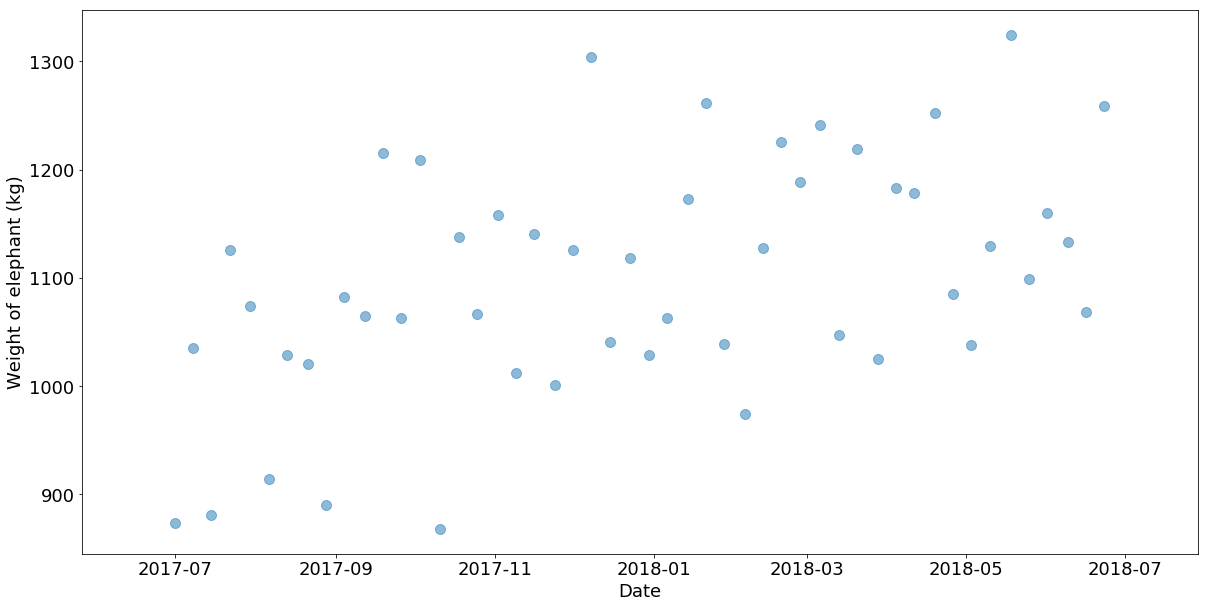

In [9]:
pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.xlabel('Date')
pyplot.ylabel('Weight of elephant (kg)')

## Distribution of the data vs uncertainty

It is impotant not confusing what “uncertainty” means and I think it’s important to be hyper clear. There’s multiple different things we can estimate the distribution for:

 - The data itself. Given a certain time frame 
(
t
,
t
′
)
, what’s the distribution of the elephant’s weight during that time interval?
 - The uncertainty of some parameter, like the parameter 
k
 in a linear relationship 
y
=
k
t
+
m
. Or the uncertainty of some estimator, like the mean of a number of observations.
 - The uncertainty of predicted quantities. So if we predict that for a date 
t
(possibly in the future), the elephant is going to weight 
y
 kg, we want to know the uncertainty of the quantity 
y
.


Let’s start with the most basic model – just break things up in buckets. I am using the Seaborn package to get some basic idea of distributions and uncertainty estimates. 

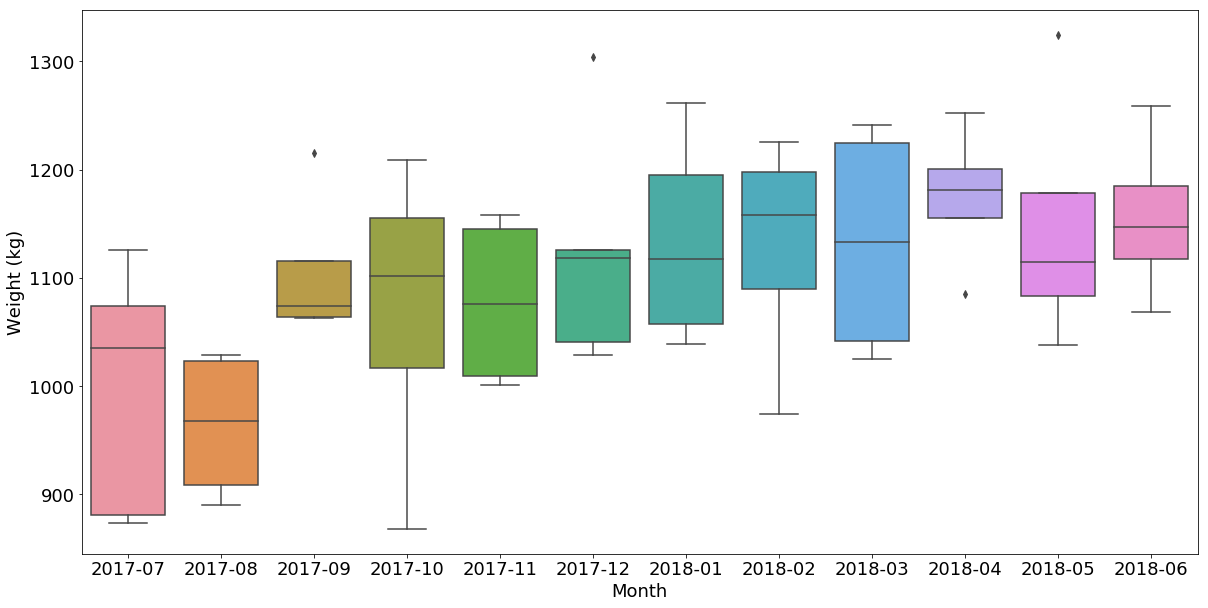

In [10]:
d = pandas.DataFrame({'x': xs, 't': ts, 'Weight (kg)': ys})
d['Month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))
seaborn.boxplot(data=d, x='Month', y='Weight (kg)')

These last charts show the distribution of the dataset. Let’s now try to figure out the uncertainty of a very common estimator: the mean!

## Computing the uncertainty of the mean – normal distributions

Under some mild assumptions (I’m going to get back to this in a sec and scrutinize it), we can compute the confidence intervals of the mean estimator as:

¯
x
±
1.96
σ
/
√
n
Where 
¯
x
 is the mean and 
σ
 is the standard deviation, a.k.a. the square root of the variance. I don’t think this formula is super important to remember, but I think it’s somewhat useful to remember that the size of the confidence interval is inversely related to the square root of the number of samples. For instance, this is useful when you’re running an A/B test – if you want to detect a 1% difference then you need something on the order of 
0.01
−
2
=
10
,
000
 samples. (This is a rule of thumb, don’t use it for your medical device software).

By the way – what’s the 1.96 number from? It’s directly related to the size of the uncertainty estimate. With 
±
1.96
 you will cover about 95% of the probability distribution.

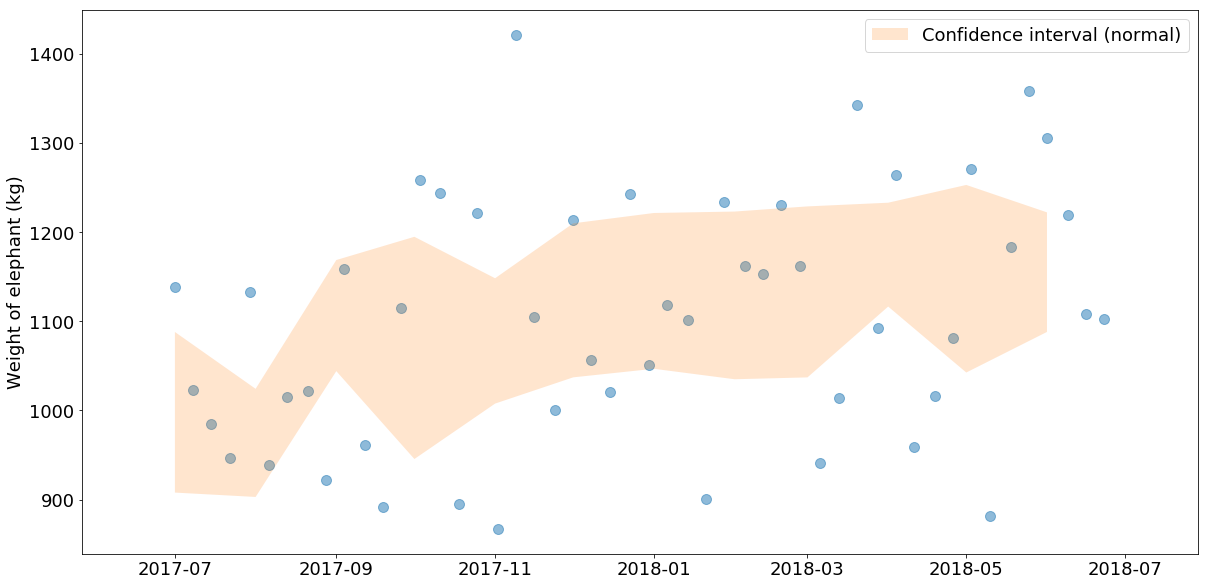

In [39]:
def plot_confidence_interval(observations_by_group):
    groups = list(sorted(observations_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_group[group]
        mu, std, n = numpy.mean(series), numpy.std(series), len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    pyplot.fill_between(groups, lo_bound, hi_bound, alpha=0.2, label='Confidence interval (normal)')

pyplot.scatter(ts, ys, alpha=0.5, s=100)
observations_by_month = {}
for month, y in zip(d['Month'], d['Weight (kg)']):
    observations_by_month.setdefault(month, []).append(y)
plot_confidence_interval(observations_by_month)
pyplot.ylabel('Weight of elephant (kg)')
pyplot.legend()

Note that this shows the **uncertainty of the mean** and that this is not the same thing as the distribution of the data itself. That’s why you see far fewer than 95% of the points within the red shaded area. If we added more and more points, the red shaded area would get more and more narrow, whereas the blue dots would still have about the same range. However the true mean should in theory be within the red shaded area 95% of the time.

I mentioned earlier that the formula for confidence interval only applies under some mild assumptions. What are those? It’s the **assumption of normality**. For a large number of observations, this is nothing to worry about, and this is due to the central limit theorem.

### Confidence intervals when all outcomes are 0 or 1

Let’s look at a type of dataset that I often work on: conversions. For the sake of the argument, let’s say we’re running an A/B test that has some impact, and that we’re trying to understand the impact on conversion rate by state. Conversion is always 0 or 1. The code to generate this data set isn’t super important, so don’t pay too much attention to this:

In [15]:
STATES = ['CA', 'NY', 'FL', 'TX', 'PA', 'IL', 'OH']
GROUPS = ['test', 'control']

def generate_binary_categorical(states=STATES, groups=GROUPS, k=400,
                                zs=[0, 0.2], z_std=0.1, b=-3, b_std=1):
    # Don't pay too much attention to this code. The main thing happens in
    # numpy.random.binomial, which is where we draw the "k out of n" outcomes.
    output = {}
    e_obs_per_state = numpy.random.exponential(k, size=len(states))
    state_biases = numpy.random.normal(b, b_std, size=len(states))
    for group, z in zip(groups, zs):
        noise = numpy.random.normal(z, z_std, size=len(states))
        ps = 1 / (1 + numpy.exp(-(state_biases + noise)))
        ns = numpy.random.poisson(e_obs_per_state)
        ks = numpy.random.binomial(ns, ps)
        output[group] = (ns, ks)
    return output

For each state and each “group” (test and control) we generated 
n
 users, out of which 
k
have converted. Let’s plot the conversion rate per state to see what’s going on!

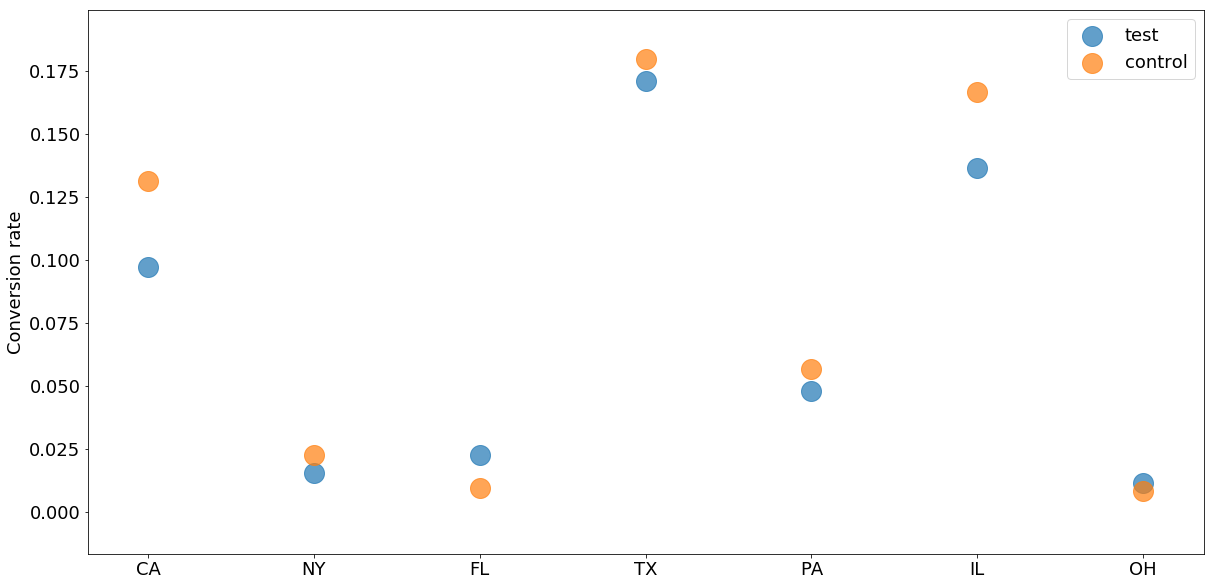

In [35]:
data = generate_binary_categorical()

for group, (ns, ks) in data.items():
    pyplot.scatter(STATES, ks/ns, label=group, alpha=0.7, s=400)

pyplot.ylabel('Conversion rate')
pyplot.legend()

How do we compute confidence intervals for these numbers? We could of course use the method I just covered further up where we compute the mean and the standard deviations. But in this case there’s a trick we can use!

Since all outcomes are 0 or 1, and drawn with the same (unknown) probability, we know that the number of ones and zeros follows a binomial distribution. This means that the confidence interval of a “
k
 out of 
n
” scenario is a Beta distribution.

Would probably make more sense memorizing the formula for the confidence interval and think I probably use it more than the previous (Normal based) one. In particular all you need to remember is

In [36]:
n, k = 100, 3
scipy.stats.beta.ppf([0.025, 0.975], k, n-k)

array([0.00629335, 0.07107612])

This will compute a 95% confidence interval if you plug in values for 
n
 and 
k
. In this case we see that if we have 100 website visitors and 3 of them purchased the product, then range is 0.6%-7.1%. Let’s try this for our dataset:



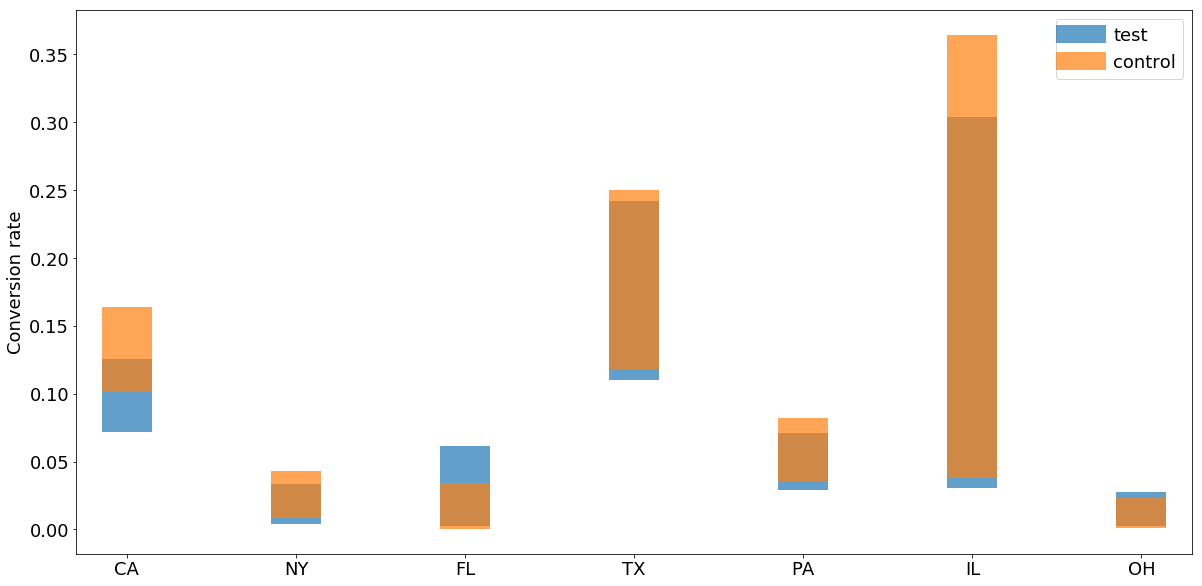

In [37]:
for group, (ns, ks) in data.items():
    lo = scipy.stats.beta.ppf(0.025, ks, ns-ks)
    hi = scipy.stats.beta.ppf(0.975, ks, ns-ks)
    mean = ks/ns
    pyplot.errorbar(STATES, y=mean, yerr=[mean-lo, hi-mean],
                    label=group, alpha=0.7, linewidth=0, elinewidth=50)

pyplot.ylabel('Conversion rate')
pyplot.legend()

Nice! 👌

Another way we could have calculate confidence interval for binary groups is by using `proportion_confint` function. Below is the same example but this time only calculating the same confidence interval with this function.

In [31]:
from statsmodels.stats import proportion

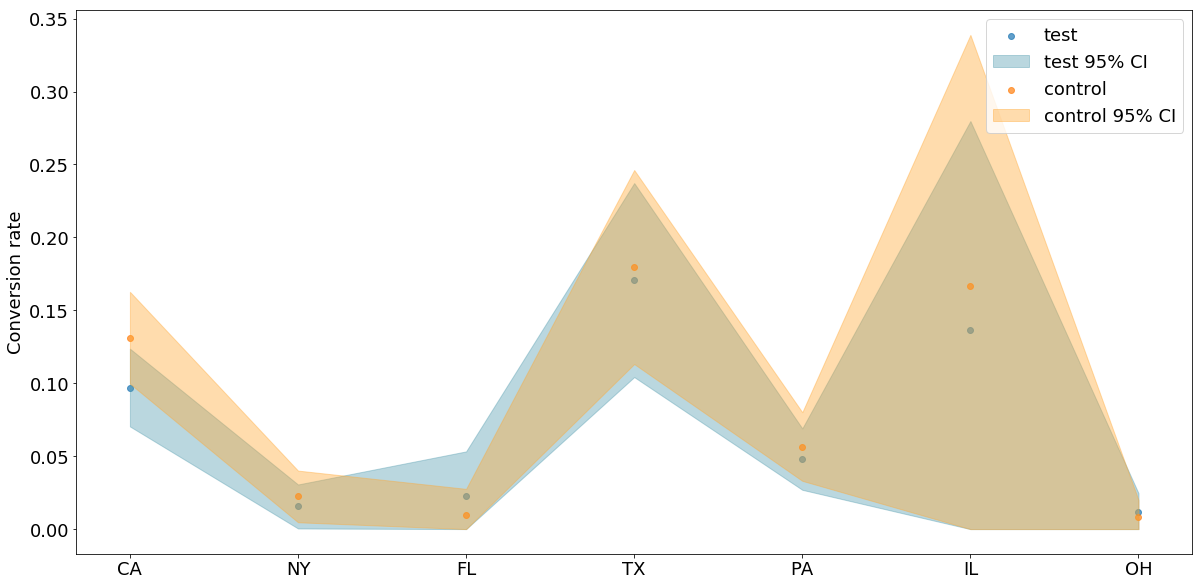

In [62]:
colors = {'test': '#539caf', 'control': '#FFA833'}

for group, (ns, ks) in data.items():
    
    low_CI, upper_CI = proportion.proportion_confint(ks, ns)
        
    path_collection = pyplot.scatter(STATES, ks/ns, label=group, alpha=0.7)
    ax = path_collection.axes
    ax.fill_between(range(0, len(ns)), low_CI, upper_CI, color = colors[group], alpha = 0.4, label = f'{group} 95% CI')
    
pyplot.ylabel('Conversion rate')
pyplot.legend()

### Bootstrapping

Another approach that can be useful is bootstrapping. It allows you do compute the same statistics without memorizing any formulas. The idea is to compute the mean, but do it for `n` bootstraps, where each bootstrap is a random sample (with replacement) from our observations. For every bootstrap, we compute a mean, and then we take the mean in the 97.5th and the 2.5th percentile as the confidence interval:

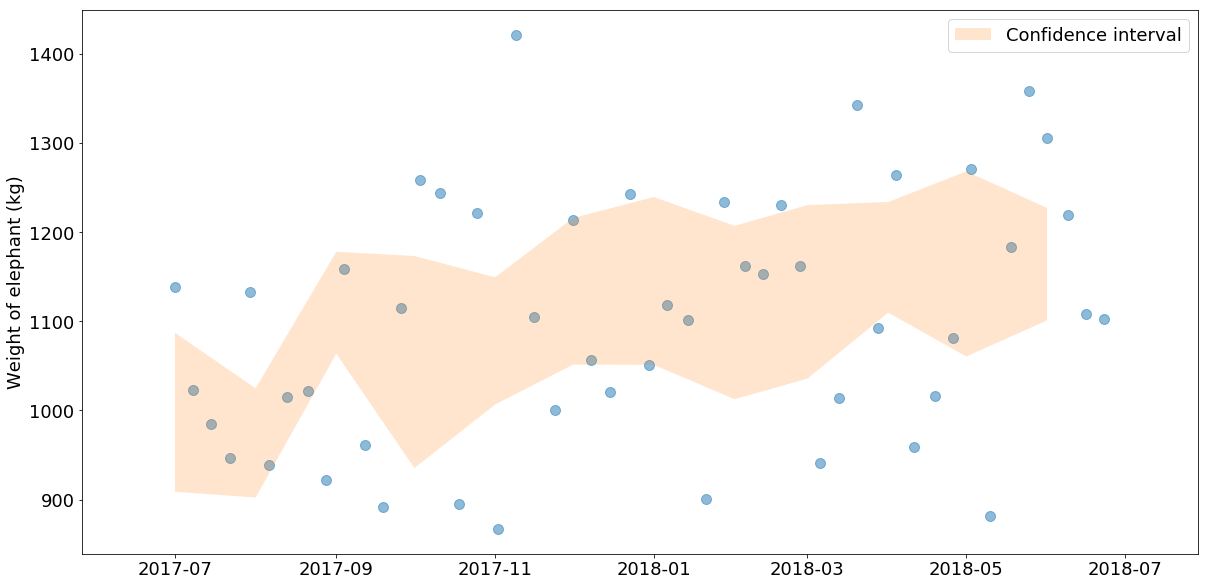

In [38]:
lo_bound = []
hi_bound = []
months = sorted(observations_by_month.keys())
for month in months:
    series = observations_by_month[month]
    bootstrapped_means = []
    for i in range(1000):
        # sample with replacement
        bootstrap = [random.choice(series) for _ in series]
        bootstrapped_means.append(numpy.mean(bootstrap))
    lo_bound.append(numpy.percentile(bootstrapped_means, 2.5))
    hi_bound.append(numpy.percentile(bootstrapped_means, 97.5))
pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.fill_between(months, lo_bound, hi_bound, alpha=0.2,
                    label='Confidence interval')
pyplot.ylabel('Weight of elephant (kg)')
pyplot.legend()

Miraculously, this charts look very similar to the one before! Just kidding – that was sort of expected :)

Bootstrapping is nice because it lets you dodge any questions about what probability distribution the data is generated from. It’s basically plug and play, and works on almost everything, though it can be a bit slow.

☠ Be aware though that there’s a danger zone of bootstrapping. My understanding is that bootstrapping will converge towards the correct estimates as the number of samples goes to infinity, but if you’re working with small samples, you can get really wonky results. I generally never trust bootstrapping for anything less than say 50 samples, and you probably shouldn’t do that either.

As a side note, Seaborn’s barplot actually plots confidence intervals using bootstrapping:

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


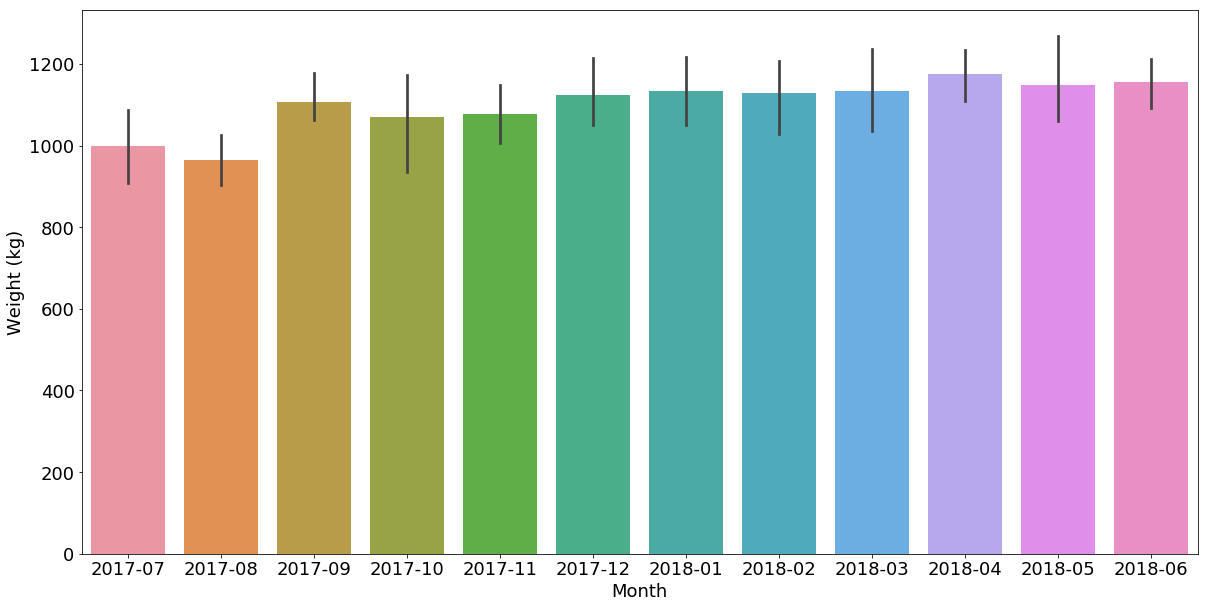

In [33]:
seaborn.barplot(data=d, x='Month', y='Weight (kg)')

Again, Seaborn is great for exploratory analysis, and some of its charts can do basic statistics.

### Regression

Let’s crank it up a notch. We’re going to fit a straight line to this cloud of points.

There’s some smart ways you can implement linear regression so that it’s extremely fast, but we’re not going to use those methods because they don’t generalize very well.

I’m going to do it in what I think of as the most general possible way. We’re going to define a model (in this case a straight line), a loss function (squared deviations from this straight line) and then optimize it using a general-purpose solver (scipy.optimize.minimize).

Text(0,0.5,'Weight of elephant (kg)')

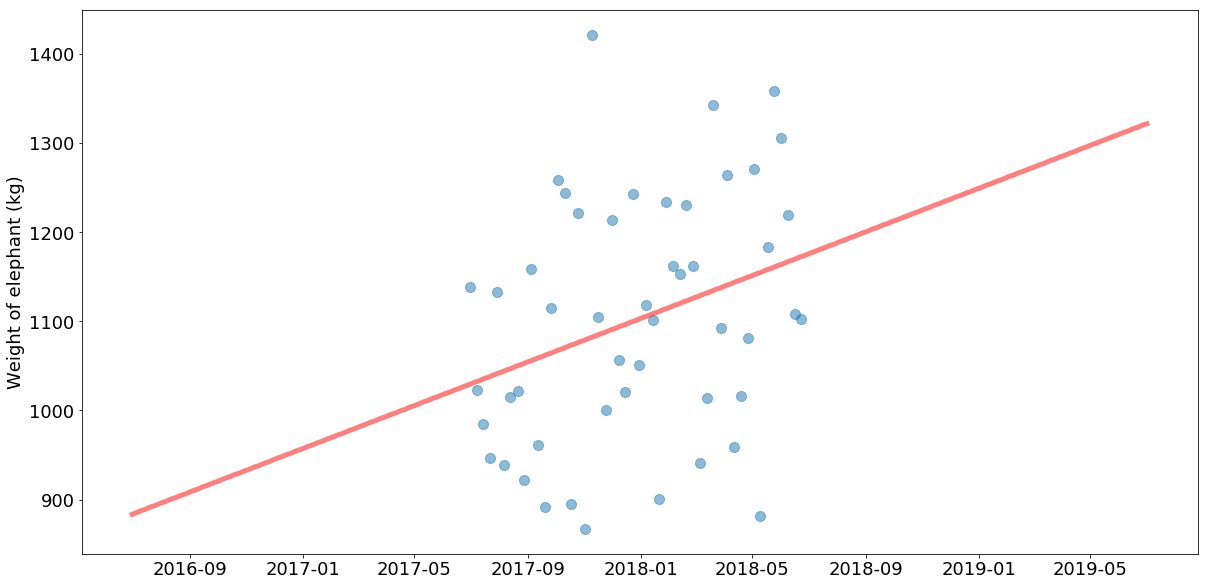

In [29]:
xs, ys, ts, x_scale, t_scale = generate_time_series()

def model(xs, k, m):
    return k * xs + m

def l2_loss(tup, xs, ys):
    k, m = tup
    delta = model(xs, k, m) - ys
    return numpy.dot(delta, delta)

k_hat, m_hat = scipy.optimize.minimize(l2_loss, (0, 0), args=(xs, ys)).x
pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.plot(t_scale, model(x_scale, k_hat, m_hat), color='red',
            linewidth=5, alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')

## Linear regression with uncertainty, using maximum likelihood

We just fit $k$ and $m$ but there's no uncertainty estimates here. There's several things we could estimate uncertainties for, but let's start with the _uncertainty of the predicted values_.

We can do that by fitting a normal distribution around the line _at the same time_ as we're fitting $k$ and $m$. I'm going to do this using [Maximum Likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). If you're not familiar with this method, don't be scared! If there's _any_ method in statistics that I've found as easily accessible (it's basic probability theory) and useful, it's this method.

In fact, minimizing squared loss (which we just did, in the previous snippet) is actually a special case of maximum likelihood! Minimizing the squared loss is the same thing as _maximizing the logarithm of the probability of all the data._ This is usually called the "log likelihood".

So we already have an expression to minimize the squared loss. If we make the variance an unknown variable $\sigma^2$ we can fit that at the same time! The quantity we're going to try to minimize now turns into

$ \frac{n}{2}\log{2\pi\sigma^2} + \frac{1}{2\sigma^2}\sum \left(y_i - \hat{y_i}\right)^2 $

Where $\hat{y_i} = kx_i + m$ are the predicted values by our model. Let's try to fit that!

No handles with labels found to put in legend.


Text(0,0.5,'Weight of elephant (kg)')

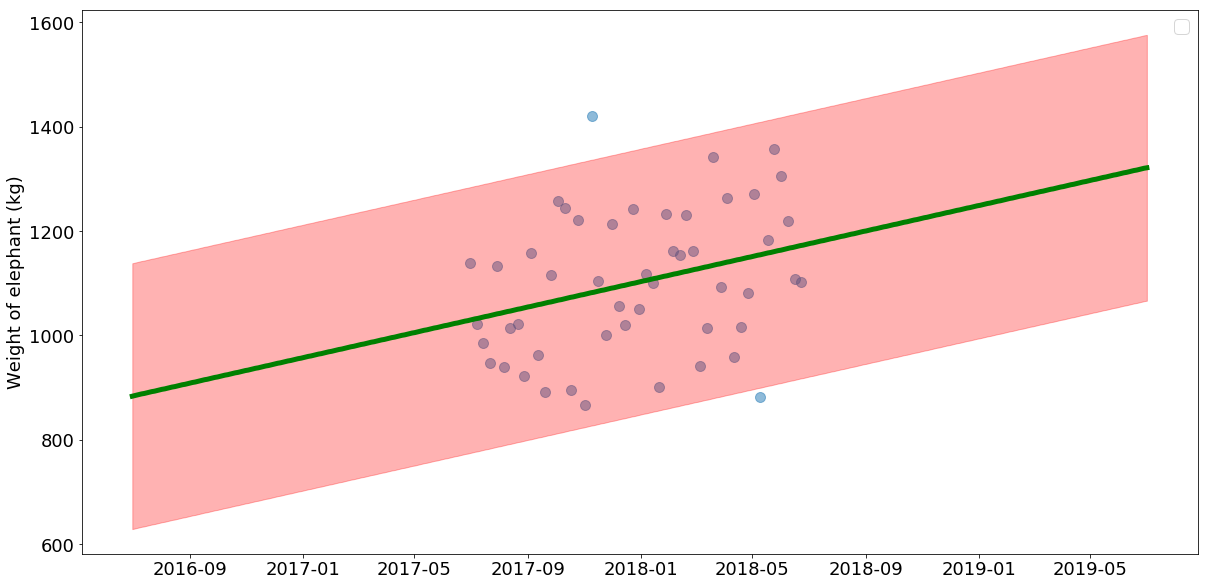

In [63]:
import scipy.optimize

def neg_log_likelihood(tup, xs, ys):
    # Since sigma > 0, we use use log(sigma) as the parameter instead.
    # That way we have an unconstrained problem.
    k, m, log_sigma = tup
    sigma = numpy.exp(log_sigma)
    delta = model(xs, k, m) - ys
    return len(xs)/2*numpy.log(2*numpy.pi*sigma**2) + \
        numpy.dot(delta, delta) / (2*sigma**2)

k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(
    neg_log_likelihood, (0, 0, 0), args=(xs, ys)
).x
sigma_hat = numpy.exp(log_sigma_hat)
pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.plot(t_scale, model(x_scale, k_hat, m_hat), color='green', linewidth=5)
pyplot.fill_between(
    t_scale,
    model(x_scale, k_hat, m_hat) - 1.96*sigma_hat,
    model(x_scale, k_hat, m_hat) + 1.96*sigma_hat,
    color='red', alpha=0.3)
pyplot.legend()
pyplot.ylabel('Weight of elephant (kg)')

The uncertainty estimate here isn't actually 💯 because it doesn't take into account the uncertainty of $k$, $m$, and $\sigma$ in itself. It's a decent approximation, but to get it right we need to do those things at the same time. So let's do it.

# Bootstrapping, again

So let's take it to the next level and try to estimate the uncertainty estimate of $k$ and $m$ _and_ $\sigma$! I think this will show how bootstrapping is basically cookie cutter – you can plug it into almost anything in order to estimate uncertainties.

For every bootstrap estimate, I'm going to draw a line. We can also take all those lines and compute a confidence interval:

/usr/local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Text(0,0.5,'Weight of elephant (kg)')

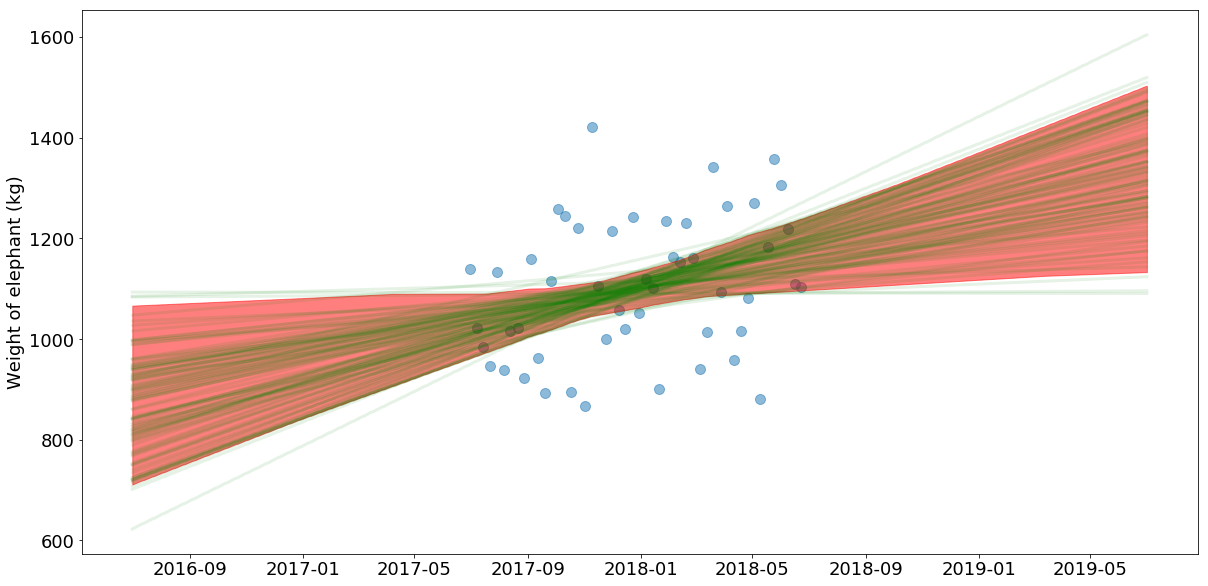

In [69]:
pyplot.scatter(ts, ys, alpha=0.5, s=100)
xys = list(zip(xs, ys))
curves = []
for i in range(100):
    # sample with replacement
    bootstrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat = scipy.optimize.minimize(
        l2_loss, (0, 0), args=(xs_bootstrap, ys_bootstrap)
    ).x
    curves.append(model(x_scale, k_hat, m_hat))

# Plot individual lines
for curve in curves:
    pyplot.plot(t_scale, curve, alpha=0.1, linewidth=3, color='green')

# Plot 95% confidence interval
lo, hi = numpy.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')

Whoa, what's going on here? This uncertainty is _very_ different from the earlier plot. This seems confusing until you realize that they show two very different things:

* The first plot finds _one_ solution of $k$ and $m$ and shows the uncertainty of the _predictions._ So, if you're asked what's the range of air pressure in the next month, you can get it from the chart.
* The second plot finds _many_ solutions of $k$ and $m$, and shows the uncertainty of $kx + m$. So this answers a different question – what's the trend of air pressure over time and what's the uncertainty _of the trend_.

It turns out we can combine the two approaches and make it even more complicated by fitting drawing bootstrap samples and fitting $k$, $m$, and $\sigma$ at the same time. Then for each of those estimates, we can predict new values $y$. Let's do it 😎.

/usr/local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Text(0,0.5,'Weight of elephant (kg)')

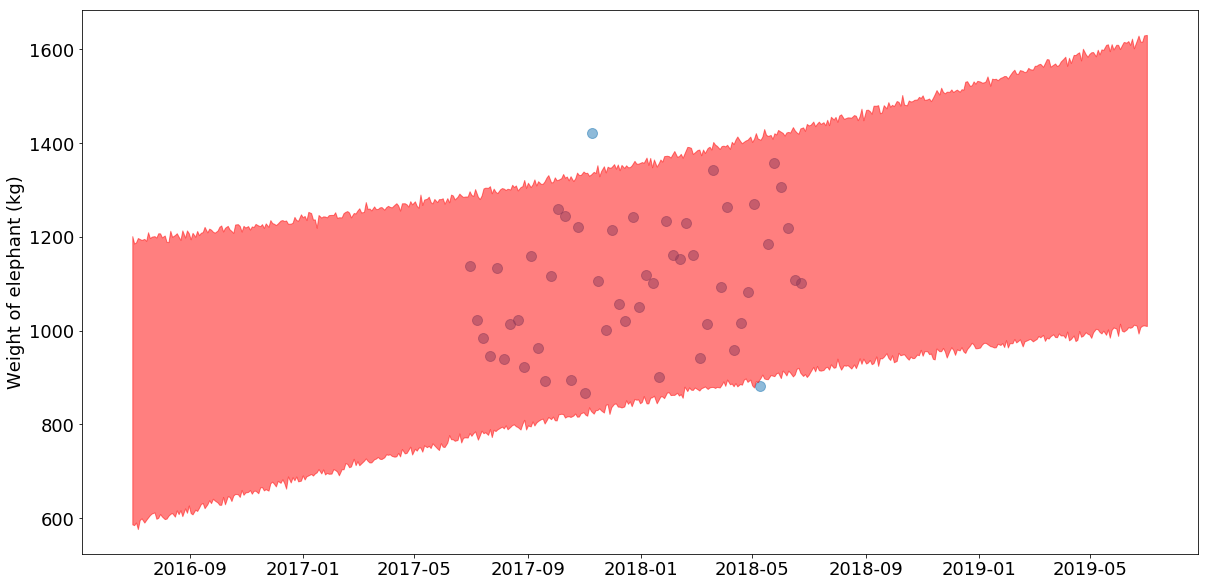

In [70]:
pyplot.scatter(ts, ys, alpha=0.5, s=100)
xys = list(zip(xs, ys))
curves = []
for i in range(4000):
    # sample with replacement
    bootstrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(
        neg_log_likelihood, (0, 0, 0), args=(xs_bootstrap, ys_bootstrap)
    ).x
    curves.append(
        model(x_scale, k_hat, m_hat) +
        # Note what's going on here: we're _adding_ the random term to the predictions!
        numpy.exp(log_sigma_hat) * numpy.random.normal(size=x_scale.shape)
    )

# Plot 95% confidence interval
lo, hi = numpy.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')

Nice! It's getting serious now 😅 – you can see a hyperbolic shape if you look closely!

The trick here is that for every bootstrap estimates of $(k, m, \sigma)$ we also need to draw random predictions. As you can see in the code, we're actually adding random normal variables to the predicted values for $y$. That's also why the shape end up a big squiggly.

Unfortunately bootstrapping turns out to be fairly slow for this problem – for each of the bootstraps, we need to fit a model. Let's look at another option:

# Markov chain Monte Carlo methods

It's going to get a bit wilder now. I'm going to switch to some Bayesian methods, where we estimate $k$, $m$, and $\sigma$ by drawing samples. It's similar to bootstrapping, but MCMC has far better theoretical underpinnings (we are sampling from a "posterior distribution" using Bayes rule), and it's often orders of magnitude faster.

For this, we're going to use a library called [emcee](http://emcee.readthedocs.io/) which I've found pretty easy to use. All it needs is a log-likelihood function, which as it turns out we just defined earlier! We just need to take the _negative_ of it.

In [73]:
try:
    import emcee
except ModuleNotFoundError: 
    import sys
    !{sys.executable} -m pip install emcee
    
    import emcee

  Running setup.py bdist_wheel for emcee ... done
  Stored in directory: /root/.cache/pip/wheels/2f/5d/a5/78f84e23329ad7d9b1787c9d24371100cae74cdefe25eba50d
Successfully built emcee
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [74]:
xs, ys, ts, x_scale, t_scale = generate_time_series()

def log_likelihood(tup, xs, ys):
    return -neg_log_likelihood(tup, xs, ys)

ndim, nwalkers = 3, 10
p0 = [numpy.random.rand(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood,
                                args=[xs, ys])
sampler.run_mcmc(p0, 10000)

(array([[193.0535788 , 975.16890968,   4.80802837],
        [189.45166747, 972.49245493,   4.72154891],
        [323.74972057, 908.28282482,   4.71288985],
        [256.93219313, 944.89471828,   4.86019734],
        [175.36043254, 972.44513555,   4.87663484],
        [371.42968583, 904.37360446,   4.88594051],
        [289.5697083 , 955.37466268,   4.94030709],
        [244.70655417, 937.28592367,   4.88430906],
        [348.1339624 , 895.58399806,   4.86487195],
        [210.36789986, 944.34457685,   4.7686437 ]]),
 array([-313.62891224, -314.60633141, -315.27453888, -313.22560638,
        -314.09718436, -315.47550142, -314.62074722, -313.6007735 ,
        -314.6143857 , -314.79885645]),
 ('MT19937', array([2385590503,  105085720, 2101797601,  768914437,   11170749,
         2963059632, 1648653380,  687829446, 3338944599, 2705768583,
          173091836,  591385536, 3553262202, 2406590119,  236211940,
         1412072214, 4063557876, 2565609775, 3537799614,  779803582,
         300284

Let's plot the sampled values for $k$ and $m$!

Text(0,0.5,'Weigh of elephant (kg)')

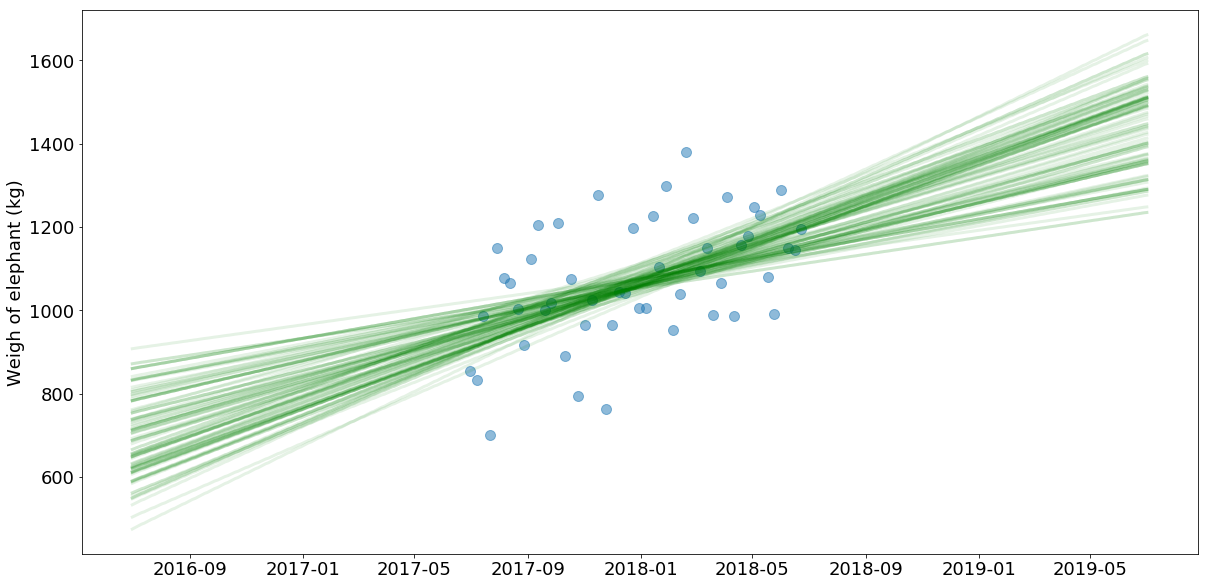

In [75]:
# Grab the last 10 from each walker
samples = sampler.chain[:, -10:, :].reshape((-1, ndim))

pyplot.scatter(ts, ys, alpha=0.5, s=100)
for k, m, log_sigma in samples:
    pyplot.plot(t_scale, model(x_scale, k, m), alpha=0.1, linewidth=3, color='green')
pyplot.ylabel('Weigh of elephant (kg)')

There's a bit more stuff that goes into these methods – the sampling is a bit finicky and requires a bit of handholding to get to work well. I don't want to get into all the specifics, and I'm a layman myself. But it can often be several orders of magnitude faster than booststrapping. It also handles situation with less data much better.

As a side note, we end up with samples from the posterior distribution of $k, m, \sigma$. We can look at the probability distribution of these unknowns:

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


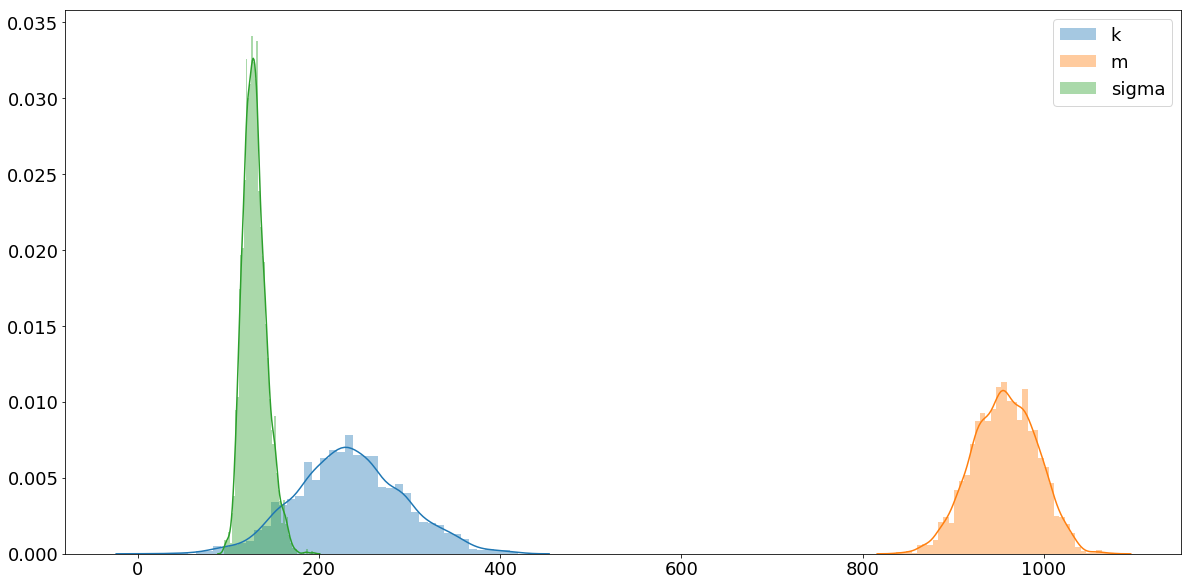

In [76]:
# Grab slightly more samples this time
samples = sampler.chain[:, -500:, :].reshape((-1, ndim))
k_samples, m_samples, log_sigma_samples = samples.T
seaborn.distplot(k_samples, label='k')
seaborn.distplot(m_samples, label='m')
seaborn.distplot(numpy.exp(log_sigma_samples), label='sigma')
pyplot.legend()

You can see that these distribution sort of center around $k=200$, $m=1000$, and $\sigma=100$ which is how we constructed them in the first place. That's somewhat reassuring!

Finally, we can plot the full uncertainty of predictions using the same methodology as for boostraps:

Text(0,0.5,'Weight of elephant (kg)')

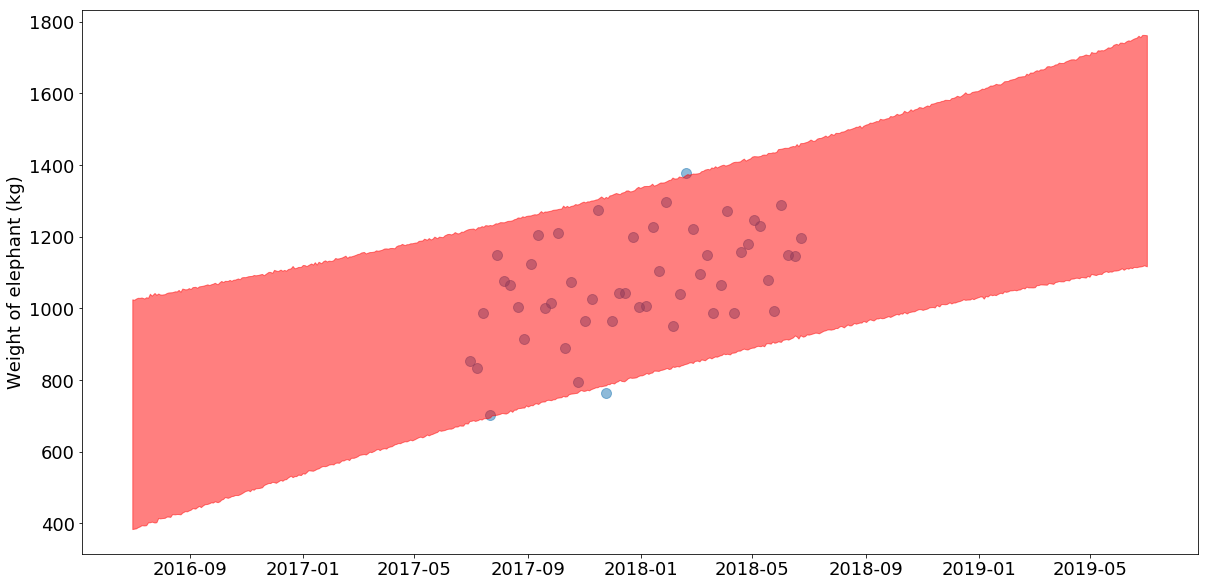

In [77]:
pyplot.scatter(ts, ys, alpha=0.5, s=100)
samples = sampler.chain[:, -4000:, :].reshape((-1, ndim))
curves = []
for k, m, log_sigma in samples:
    curves.append(
        model(x_scale, k, m) +
        numpy.exp(log_sigma) * numpy.random.normal(size=x_scale.shape)
    )

# Plot 95% confidence interval
lo, hi = numpy.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')

These Bayesian methods don't end here. In particular there's several libraries that work with these kind of problems. It turns out that if you express the problem in a more structured way (not just a negative log-likelihood function), you can make the sampling scale to large problems (as in, thousands of unknown parameters). For Python there's [PyMC3](https://docs.pymc.io/) and [PyStan](http://pystan.readthedocs.io/en/latest/), as well as the slightly more experimental (?) [Edward](http://edwardlib.org/) and [Pyro](http://pyro.ai/).

# Final words

Making decisions based on data is hard! But if we were a bit more disciplined about quantifying the uncertainty, we might make better decisions. It's not easy right now to do this! I _really_ hope we'll see a popularization of these methods using more accessible tools.

This notebook is based on this great [blog post](https://erikbern.com/2018/10/08/the-hackers-guide-to-uncertainty-estimates.html) and its [jupiter notebook](https://github.com/erikbern/uncertainty/blob/master/notebook.ipynb)

